<a href="https://colab.research.google.com/github/fan-of-dark/UNET_Segmentation/blob/main/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!pip install keras

In [ ]:
import keras
keras.__version__

'2.5.0'

#0. Importing Libraries

In [ ]:
import os
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("dark_background")

In [ ]:
from keras.models import Model, Sequential,load_model
from keras.layers import Conv2D, MaxPool2D, Conv2DTranspose
from keras.layers import Dropout, Lambda
from keras.layers.merge import concatenate
from keras.layers import Input, BatchNormalization, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

from keras import backend as K
import tensorflow as tf

import warnings
import random
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#1. Getting Data 

[Using Kaggle API with colab](https://medium.com/@yvettewu.dw/tutorial-kaggle-api-google-colaboratory-1a054a382de0#:~:text=Download%20Data%3A%20Go%20to%20the%20Kaggle%20competition%20page,API%20button%2C%20it%20will%20copy%20the%20command%20automatically.)

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!ls ~/.kaggle

In [ ]:
token = {"username":"saivikassingamsetty","key":"0c6fd21a20e9c4b8210ec1a1a0e3d762"}

In [ ]:
import json
with open("/root/.kaggle/kaggle.json", "w") as file:
  #encodes python objects to json objects
  json.dump(token,file)

In [ ]:
#chmod changes the permissions of each given file according to mode, where mode describes the permissions to modify.
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/9.10M [00:00<?, ?B/s]
100% 9.10M/9.10M [00:00<00:00, 84.3MB/s]
  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 2.40MB/s]
 94% 259M/276M [00:02<00:00, 137MB/s]
100% 276M/276M [00:02<00:00, 121MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 172MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 115MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 127MB/s]
 80% 63.0M/79.1M [00:00<00:00, 116MB/s] 
100% 79.1M/79.1M [00:00<00:00, 197MB/s]


In [ ]:
!ls

drive				  stage1_train_labels.csv.zip
sample_data			  stage1_train.zip
stage1_sample_submission.csv.zip  stage2_sample_submission_final.csv.zip
stage1_solution.csv.zip		  stage2_test_final.zip
stage1_test.zip


In [ ]:
from zipfile import ZipFile
def unzip_to_folder(fname,target):
  with ZipFile(fname, "r") as f:
    f.extractall(target)

In [ ]:
unzip_to_folder("/content/stage1_train.zip", "/content/dataset/train")
unzip_to_folder("/content/stage1_test.zip", "/content/dataset/test")
unzip_to_folder("/content/stage1_train_labels.csv.zip", "/content/dataset/train_labels")

#2. Data understanding

In [ ]:
train_path = "/content/dataset/train/"
test_path = "/content/dataset/test/"
train_labels_path = "/content/dataset/train_labels"

In [ ]:
print(len(os.listdir(train_path)))
print(len(os.listdir(test_path)))

670
65


In [ ]:
#getting train and test image ids
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

In [ ]:
len(train_ids)

670

In [ ]:
# Setting some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

#3. Data Preprocessing

In [ ]:
#initializing 2 datas for training
#image data
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
#target or mask data
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

In [ ]:
#Tqdm is a Python library used to display smart progress bars that show the progress of your Python code execution.
#used to see progress of ML model training on large datasets
from tqdm import tqdm

In [ ]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

In [ ]:
#works like a conventional iterator but dynamically update the progress bar.
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
  
  file_path = train_path + id_

  #IMAGE file
  img = imread(file_path + "/images/" + id_ + ".png")[:,:,:3] #as image channels are 3
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = "constant", preserve_range = True)
  X_train[n] = img

  #MASK file
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
  #os.walk gives a generator object, as first 2 are paths, just need to traverse along the masks
  for maskfile in next(os.walk(file_path + "/masks/"))[2]:
    mask_  = imread(file_path + "/masks/" + maskfile)
    #creates the mask layers like a pile.
    mask_ = np.expand_dims(a = resize(mask_, (IMG_HEIGHT, IMG_WIDTH),
                                          mode = "constant", preserve_range= True),
                           axis = -1)
    #final mask layer is one np array containing all the masks, as they are no overlapping masks.
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask

100%|██████████| 670/670 [05:56<00:00,  1.88it/s]


In [ ]:
#same for the test images too

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
sizes = []

for n,id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
  file_path = test_path + id_
  img = imread(file_path + "/images/"+ id_ + ".png")[:,:,:IMG_CHANNELS]
  sizes.append((img.shape[0], img.shape[1]))
  #interpolation resize
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = "constant", preserve_range= True)
  X_test[n] = img

100%|██████████| 65/65 [00:01<00:00, 36.91it/s]


In [ ]:
X_train.shape

(670, 128, 128, 3)

In [ ]:
Y_train.shape

(670, 128, 128, 1)

In [ ]:
X_test.shape

(65, 128, 128, 3)

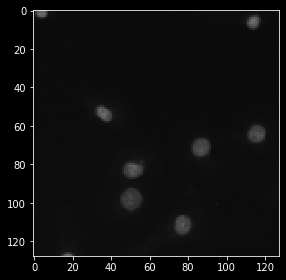

In [ ]:
#checking training data images
i = np.random.randint(0, len(train_ids))
imshow(X_train[i])
plt.show()

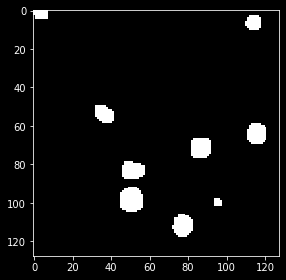

In [ ]:
#checking training data masks
imshow(np.squeeze(Y_train[i]))
plt.show()

#4. Building UNET


In [ ]:
def DoubleConv(inp, filters, dropout):
  # A 3X3 2D conv-dropout-conv trio
  layer1 = Conv2D(filters = filters, kernel_size = (3,3), activation= "elu", kernel_initializer= "he_normal", padding = "same")(inp)
  layer2 = Dropout(rate = dropout)(layer1)
  out = Conv2D(filters= filters, kernel_size= (3,3), activation= "elu", kernel_initializer= "he_normal", padding = "same")(layer2)
  return out

In [ ]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x /255)(inputs)

#ENCODER
c1 = DoubleConv(s, 16, 0.1)

p1 = MaxPool2D((2,2))(c1)

c2 = DoubleConv(p1, 32, 0.1)
p2 = MaxPool2D((2,2))(c2)

c3 = DoubleConv(p2, 64, 0.1)
p3 = MaxPool2D((2,2))(c3)

c4 = DoubleConv(p3, 128, 0.1)
p4 = MaxPool2D((2,2))(c4)

c5 = DoubleConv(p4, 256, 0.1)

#DECODER
u6 = Conv2DTranspose(128, (2,2), strides = (2,2), padding = "same")(c5)
u6 = concatenate([u6, c4])
c6 = DoubleConv(u6, 128, 0.2)

u7 = Conv2DTranspose(64, (2,2), strides = (2,2), padding = "same")(c6)
u7 = concatenate([u7, c3])
c7 = DoubleConv(u7, 64, 0.2)

u8 = Conv2DTranspose(32, (2,2), strides = (2,2), padding = "same")(c7)
u8 = concatenate([u8, c2])
c8 = DoubleConv(u8, 32, 0.1)

u9 = Conv2DTranspose(16, (2,2), strides = (2,2), padding = "same")(c8)
u9 = concatenate([u9, c1])
c9 = DoubleConv(u9, 16, 0.1)

#final layer
outputs = Conv2D(1, (1,1), activation= "sigmoid")(c9)

#model
model = Model(inputs = [inputs], outputs = [outputs])

#5. Parameters

In [ ]:
from keras.metrics import MeanIoU

In [ ]:
model.compile(optimizer= "adam", loss='binary_crossentropy', metrics=[MeanIoU(num_classes= 2)])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

#6. Training UNET

In [ ]:
history = model.fit(X_train, Y_train, validation_split= 0.11, batch_size= 16, epochs = 25)

Epoch 1/25
38/38 [==============================] - 53s 129ms/step - loss: 0.5220 - mean_io_u: 0.3996 - val_loss: 0.2526 - val_mean_io_u: 0.3937
Epoch 2/25
38/38 [==============================] - 2s 42ms/step - loss: 0.1822 - mean_io_u: 0.3966 - val_loss: 0.2016 - val_mean_io_u: 0.3937
Epoch 3/25
38/38 [==============================] - 2s 42ms/step - loss: 0.1334 - mean_io_u: 0.4017 - val_loss: 0.1413 - val_mean_io_u: 0.3937
Epoch 4/25
38/38 [==============================] - 2s 42ms/step - loss: 0.1429 - mean_io_u: 0.3987 - val_loss: 0.1624 - val_mean_io_u: 0.3937
Epoch 5/25
38/38 [==============================] - 2s 42ms/step - loss: 0.1148 - mean_io_u: 0.4046 - val_loss: 0.1263 - val_mean_io_u: 0.3937
Epoch 6/25
38/38 [==============================] - 2s 42ms/step - loss: 0.1022 - mean_io_u: 0.4091 - val_loss: 0.1327 - val_mean_io_u: 0.3937
Epoch 7/25
38/38 [==============================] - 2s 42ms/step - loss: 0.0981 - mean_io_u: 0.4054 - val_loss: 0.1250 - val_mean_io_u: 0.39

Text(0.5, 1.0, 'Training and validation loss')

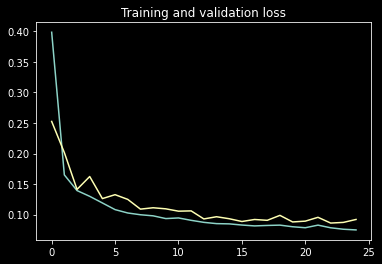

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.figure()

plt.plot(epochs,loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

#7. Testing UNET

In [ ]:
X_test.shape

(65, 128, 128, 3)

In [ ]:
y_hat = model.predict(X_test, verbose = 1)

3/3 [==============================] - 2s 148ms/step


In [ ]:
#visualizing predictions
y_hat.shape

(65, 128, 128, 1)

(128, 128, 3)


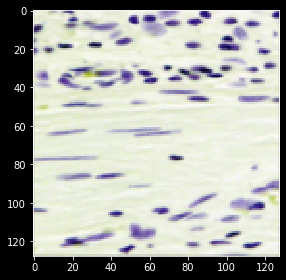

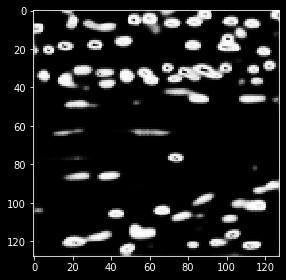

In [ ]:
id = np.random.randint(0,len(X_test)-1) #39,4
print(X_test[id].shape)
imshow(X_test[id])
plt.show()
imshow(y_hat[id][:,:,0])
plt.show()

# END